## Optimization lecture 13: L2-regularized reconstruction

In [1]:
#%pip install scikit-image
## MP 573 Part 2, Lecture 13: L2 regularization for image recon
##
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
from scipy import signal
import scipy.io as sio
import scipy.optimize as opt
import numpy.random as rnd
import scipy.sparse as sparse
from skimage import data as skdata # type: ignore
from skimage import transform


font = {'weight' : 'normal',
        'size'   : 18}
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

In [2]:
# Fitting 1/2[|| Px - d ||^2 + lambda ||WDx||^2]
# 1/2 || [P;sqrt(lambda)WD]x - [d;0] ||^2
# This function returns the value of our cost function
# Note the 1/2 factor, to keep consistent with the CG notation presented in HW2
def evalFun2(x,N,M,data,theta,lam,D,w):
    
    # Collect the relevant array sizes and reshape some arrays for convenience
    N1 = N[0]
    N2 = N[1]    
    M1 = M[0]
    M2 = M[1]
    data = np.reshape(data,(M1*M2,1)) # Reshape the measured data as a column vector
    wvec = np.reshape(w,(N1*N2,1)) # Reshape the weights map as a column vector
    
    # Calculate Px (Radon transform, then reshape as column vector)
    px1 = transform.radon(np.reshape(x,(N1,N2)), theta=theta, circle=False)
    px = np.reshape(px1,(M1*M2,1))

    # Calculate f = 1/2[|| Px - d ||^2 + lambda ||WDx||^2]
    f = 1/2*(la.norm(px-data)**2 + lam*la.norm(wvec*(D.dot(np.reshape(x,(N1*N2,1)))))**2)
      
    return f



In [3]:
# Fitting 1/2[|| Px - d ||^2 + lambda ||WDx||^2]
# 1/2 || [P;sqrt(lambda)WD]x - [d;0] ||^2
# This function returns the value and gradient of our cost function
# Note the 1/2 factor, to keep consistent with the CG notation presented in HW2
def evalGradients2(x,N,M,data,theta,lam,D,w):
    
    # Collect the relevant array sizes and reshape some arrays for convenience
    N1 = N[0]
    N2 = N[1]
    M1 = M[0]
    M2 = M[1]
    data = np.reshape(data,(M1*M2,1)) # Reshape the measured data as a column vector
    wvec = np.reshape(w,(N1*N2,1)) # Reshape the weights map as a column vector
    
    # Calculate Px (Radon transform, then reshape as column vector)
    px1 = transform.radon(np.reshape(x,(N1,N2)), theta=theta, circle=False)
    px = np.reshape(px1,(M1*M2,1))
    
    # Calculate f = 1/2[|| Px - d ||^2 + lambda ||WDx||^2]
    f = 1/2*(la.norm(px-data)**2 + lam*la.norm(wvec*(D.dot(np.reshape(x,(N1*N2,1)))))**2)
    
    # Calculate the gradient g (a vector): P^T P x - P^T d + lambda D^T W^T W D x 
    PTPx = 2*M2/np.pi*transform.iradon(px1, theta=theta, circle=False, filter_name=None, interpolation='cubic')    
    PTd = 2*M2/np.pi*transform.iradon(np.reshape(data,(M1,M2)), theta=theta, circle=False, filter_name=None, interpolation='cubic')
    WTWDx = wvec*wvec*(D.dot(np.reshape(x,(N1*N2,1))))
    g = np.reshape(PTPx,(N1*N2,1)) + lam*(D.T).dot(WTWDx) - np.reshape(PTd,(N1*N2,1))
        
    return f,g


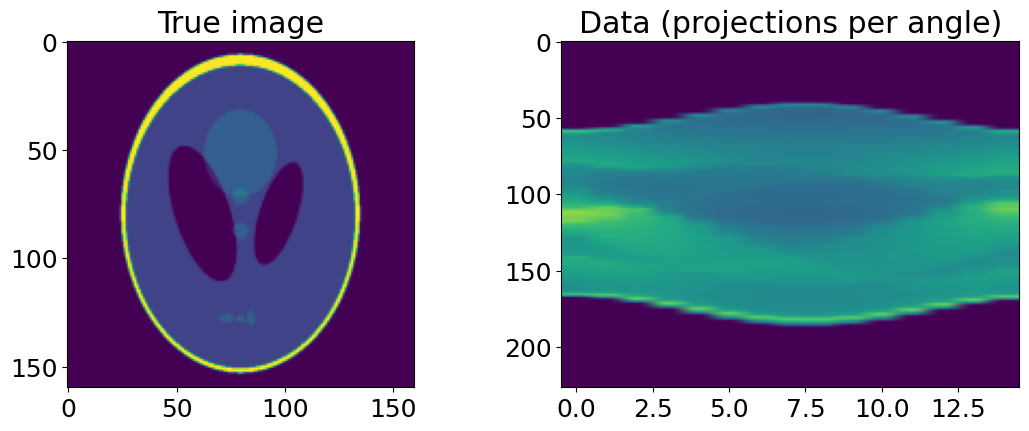

In [34]:
# Similarly to homework 6, WHICH_PROBLEM indicates:
# 1: LS without regularization
# 2: LS with smoothness regularization
# 3: LS with anatomically-weighted smoothness regularization
WHICH_PROBLEM = 3 

#Here's the data
data_dir = pjoin('.', 'data')
xtrue = skdata.shepp_logan_phantom() # Load the shep-logan phantom
xtrue = transform.rescale(xtrue, scale=0.4) # Make a bit smaller
N1,N2 = xtrue.shape # Size of our image
theta = np.linspace(0., 180., 15, endpoint=False) # These are our projection angles
data = transform.radon(xtrue, theta=theta, circle=False) # Radon transform
M1,M2 = data.shape # Size of the Radon-transformed data (points per projection x Nprojections)
datavec = np.reshape(data,(M1*M2)) # Here's our data as a column vector


# Here's a 2D finite-difference taking matrix (see lecture 32)
I = np.eye(N1)
D = 2*I - np.roll(I,-1,axis=1) - np.roll(I,1,axis=1)
D = sparse.csr_matrix(D) 
I = sparse.eye(N1)
D2 = sparse.kron(D,I) + sparse.kron(I,D) # Difference-taking matrix in 2D

if WHICH_PROBLEM == 1: # 1: LS without regularization
    w = np.ones((N1,N2)) # Uniform weights (although this doesn't matter since lambda=0)
    lam = 0 # lambda = 0, ie: no smoothness term
elif WHICH_PROBLEM == 2: # 2: LS with smoothness regularization
    w = np.ones((N1,N2))  # Uniform weights   
    lam = 1E2 # Example: can try 1E2, 1E5
else: # if WHICH_PROBLEM == 3: # 3: LS with anatomically-weighted smoothness regularization
    Dx = np.abs(D2.dot(np.reshape(xtrue,(N1*N2,1))))
    Dx = Dx/np.max(Dx)
    w = 1-Dx 
    w[w<0.95] = 0.0 # Weights do not penalize edges in locations where we know there are edges
    lam = 1E2 # Regularization parameter

niter = 100 # Number of overall descent iterations
niterGS = 20 # Number of golden section search iterations within each SD iteration
INIT_FBP = 0 # Initialize iterative algorithms with the FBP recon

wvec = np.reshape(w,(N1*N2,1)) # Reshape weights map as a column vector

# Display the true image and projection data (sinogram)
#plt.figure(figsize=(4,4))
#imgplot = plt.imshow(abs(np.reshape(xtrue,(N1,N2))),cmap='gray',vmin=0,vmax=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5))
plt.rc('font', **font)
ax1.set_title("True image")
ax1.imshow(xtrue, vmin=0, vmax=1)
ax2.set_title("Data (projections per angle)")
ax2.imshow(data, vmin=0, vmax=50, aspect='auto');


FBP: cost function = 
43737.9


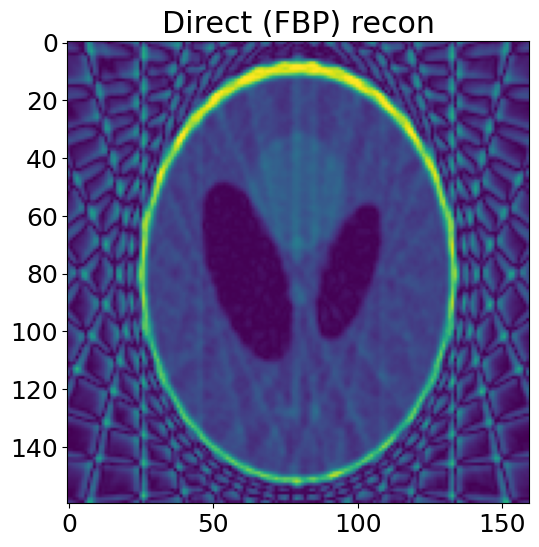

In [35]:
# Filtered backprojection
x1 = transform.iradon(data, theta=theta, circle=False, filter_name='hamming')

# Display reconstructed image
plt.figure(figsize=(6,6))
imgplot = plt.imshow(abs(np.reshape(x1,(N1,N2))),vmin=0,vmax=1)
plt.rc('font', **font)
plt.title('Direct (FBP) recon')

# We can evaluate our cost function at the FPB solution
f = evalFun2(x1,[N1,N2],[M1,M2],datavec,theta,lam,D2,w)
print('FBP: cost function = ')
print("%.1f" % f)

Algorithm: Steepest Descent
Done, cost function = 
408.1


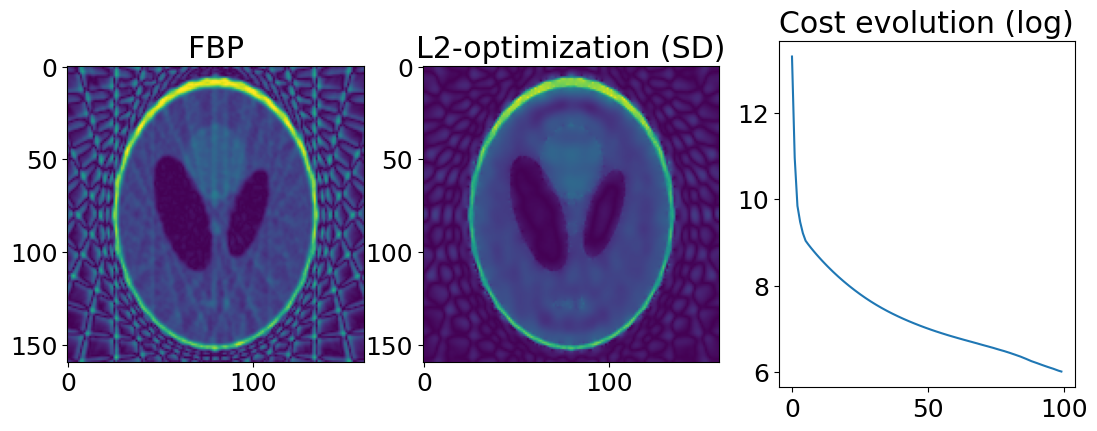

In [36]:
print('Algorithm: Steepest Descent')
if INIT_FBP>0: # Initialize with the FBP recon
    x = x1
else: # Initialize with all zeros
    x = 0*x1

allfSD = np.zeros(niter) # Array to keep track of cost function through the iterations

x = np.reshape(x,(N1*N2,1))
for k in range(0,niter): # Main iterations: find g and descend along SD direction (-g)
    f,g = evalGradients2(x,[N1,N2],[M1,M2],datavec,theta,lam,D2,w) # Calculate cost and gradient
    

    if la.norm(g)>0.000001: # If gradient is not tiny (ie: if no convergence yet)
        d = -g/np.max(abs(g)) # Normalizing gradient to get reasonable step size
        a0 = 0 # Initialize GS search
        b0 = 1 # Initialize GS search
        for kg in range(0,niterGS): # Golden section search within each iteration
            a1 = x + d*a0 + d*(b0-a0)*0.382;
            b1 = x + d*a0 + d*(b0-a0)*0.618;
            fa1 = evalFun2(a1,[N1,N2],[M1,M2],datavec,theta,lam,D2,w)
            fb1 = evalFun2(b1,[N1,N2],[M1,M2],datavec,theta,lam,D2,w)
            if fb1<fa1:
                a0 = a0 + 0.382*(b0-a0);
            else:
                b0 = a0 + 0.618*(b0-a0);       
                
        alpha = (a0+b0)/2; # Set step size as the average of a0 and b0
        allfSD[k] = f

        # If we actually made the cost smaller, let's apply the step
        xtentative = x + alpha*d; # Let us check that we actually descend
        ftentative = evalFun2(xtentative,[N1,N2],[M1,M2],datavec,theta,lam,D2,w)
        if ftentative < f:
            x = xtentative;
        else:
            print("No descent, may need more GS iterations/smaller step")

# Collect output and display results        
xSD = np.reshape(x,(N1,N2))        
print('Done, cost function = ')
print("%.1f" % f)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4.5))
plt.rc('font', **font)
ax1.set_title("FBP")
ax1.imshow(abs(np.reshape(x1,(N1,N2))), vmin=0, vmax=1)
ax2.set_title("L2-optimization (SD)")
ax2.imshow(abs(xSD), vmin=0, vmax=1)
ax3.set_title("Cost evolution (log)")
ax3.plot(np.log(allfSD));

Algorithm: Conjugate Gradients
Done, cost function = 
2.9


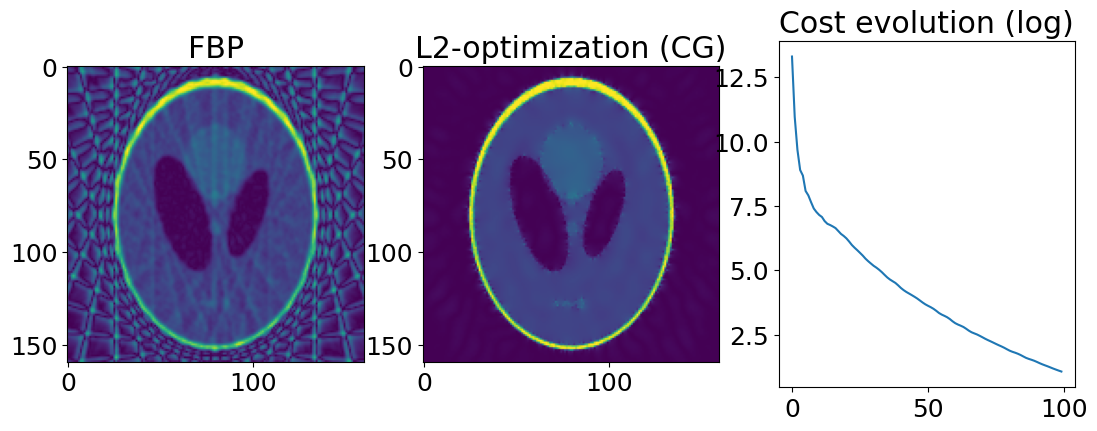

In [37]:
print('Algorithm: Conjugate Gradients')
if INIT_FBP>0: # Initialize with the FBP recon
    x = x1
else: # Initialize with all zeros
    x = 0*x1
    
x = np.reshape(x,(N1*N2,1)) # Reshape our recon initial guess as a vector
    
allfCG = np.zeros(niter) # Array to keep track of cost function through the iterations

f,g = evalGradients2(x,[N1,N2],[M1,M2],datavec,theta,lam,D2,w)
allfCG[0] = f 
if la.norm(g)>0.000001:
    d = -g
    k=1;
    while k < niter: # CG Iterations
        Pd = transform.radon(np.reshape(d,(N1,N2)), theta=theta, circle=False)
        PTPd = 2*M2/np.pi*transform.iradon(Pd, theta=theta, circle=False, filter_name=None, interpolation='cubic')
        WTWDd = wvec*wvec*(D2.dot(np.reshape(d,(N1*N2,1))))
        Qd = np.reshape(PTPd,(N1*N2,1)) + lam*(D2.T).dot(WTWDd)
        a = -((np.conj(g.T)).dot(d))/(np.conj(d.T).dot(Qd)); # CG step size
        xold = x
        x = x + a*d; # CG update
        f,g = evalGradients2(x,[N1,N2],[M1,M2],datavec,theta,lam,D2,w)
        allfCG[k] = f

        if la.norm(g)>0.000001: # If no convergence yet (gradient not tiny), keep going
            b = (np.conj(g.T).dot(Qd))/(np.conj(d.T).dot(Qd)); # CG factor to combine current gradient with previous direction
            d = -g + b*d; # CG direction update
        else: # If gradient is tiny, we are done
            k = niter

        # If things go wrong, run for safety (use a gradient descent iteration)
#        if  allfCG[k] > allfCG[k-1]:
#            allfCG[k] = allfCG[k-1]
#            x = xold;
#            f,g = evalGradients2(x,[N1,N2],[M1,M2],datavec,theta,lam,D2,w)
#            d = -g
            
        k = k+1

# Collect output and display results        
xCG = np.reshape(x,(N1,N2))        
print('Done, cost function = ')
print("%.1f" % f)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4.5))
plt.rc('font', **font)
ax1.set_title("FBP")
ax1.imshow(abs(np.reshape(x1,(N1,N2))), vmin=0, vmax=1)
ax2.set_title("L2-optimization (CG)")
ax2.imshow(abs(xCG), vmin=0, vmax=1)
ax3.set_title("Cost evolution (log)")
ax3.plot(np.log(allfCG));

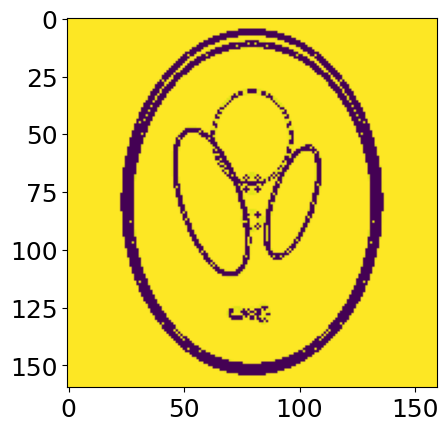

In [38]:
# Let's show the weights used in this reconstruction
plt.imshow(abs(np.reshape(w,(N1,N2))), vmin=0, vmax=1);